In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor

In [ ]:


train_df = pd.read_csv('/content/drive/MyDrive/Napqueen_comp_data/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Napqueen_comp_data/test (1).csv')
sample_submission_df = pd.read_csv('/content/drive/MyDrive/Napqueen_comp_data/sample_submission.csv')

# Display the first few rows of each dataset
train_df.head(), test_df.head(), sample_submission_df.head()


(                      ID        date     Item Id  \
 0  2022-04-12_B09KDTS4DC  2022-04-12  B09KDTS4DC   
 1  2022-04-12_B09MR2MLZH  2022-04-12  B09MR2MLZH   
 2  2022-04-12_B09KSYL73R  2022-04-12  B09KSYL73R   
 3  2022-04-12_B09KT5HMNY  2022-04-12  B09KT5HMNY   
 4  2022-04-12_B09KTF8ZDQ  2022-04-12  B09KTF8ZDQ   
 
                                            Item Name  ad_spend anarix_id  \
 0  NapQueen Elizabeth 8" Gel Memory Foam Mattress...       NaN  NAPQUEEN   
 1  NapQueen 12 Inch Bamboo Charcoal Queen Size Me...       NaN  NAPQUEEN   
 2     NapQueen Elsa 8" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   
 3        NapQueen Elsa 6" Innerspring Mattress, Twin       NaN  NAPQUEEN   
 4     NapQueen Elsa 6" Innerspring Mattress, Twin XL       NaN  NAPQUEEN   
 
    units  unit_price  
 0    0.0         0.0  
 1    0.0         0.0  
 2    0.0         0.0  
 3    0.0         0.0  
 4    0.0         0.0  ,
                       ID        date     Item Id  \
 0  2024-07-01_B09

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101490 entries, 0 to 101489
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ID          101490 non-null  object 
 1   date        101490 non-null  object 
 2   Item Id     101488 non-null  object 
 3   Item Name   99658 non-null   object 
 4   ad_spend    77303 non-null   float64
 5   anarix_id   101490 non-null  object 
 6   units       83592 non-null   float64
 7   unit_price  101490 non-null  float64
dtypes: float64(3), object(5)
memory usage: 6.2+ MB
None

Test Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2833 entries, 0 to 2832
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          2833 non-null   object 
 1   date        2833 non-null   object 
 2   Item Id     2833 non-null   object 
 3   Item Name   2489 non-null   object 
 4   ad_spend    1382

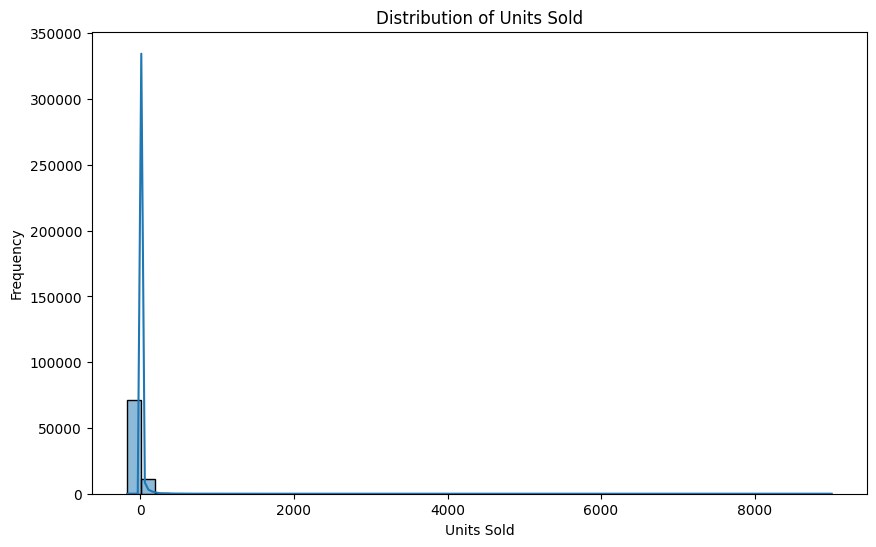

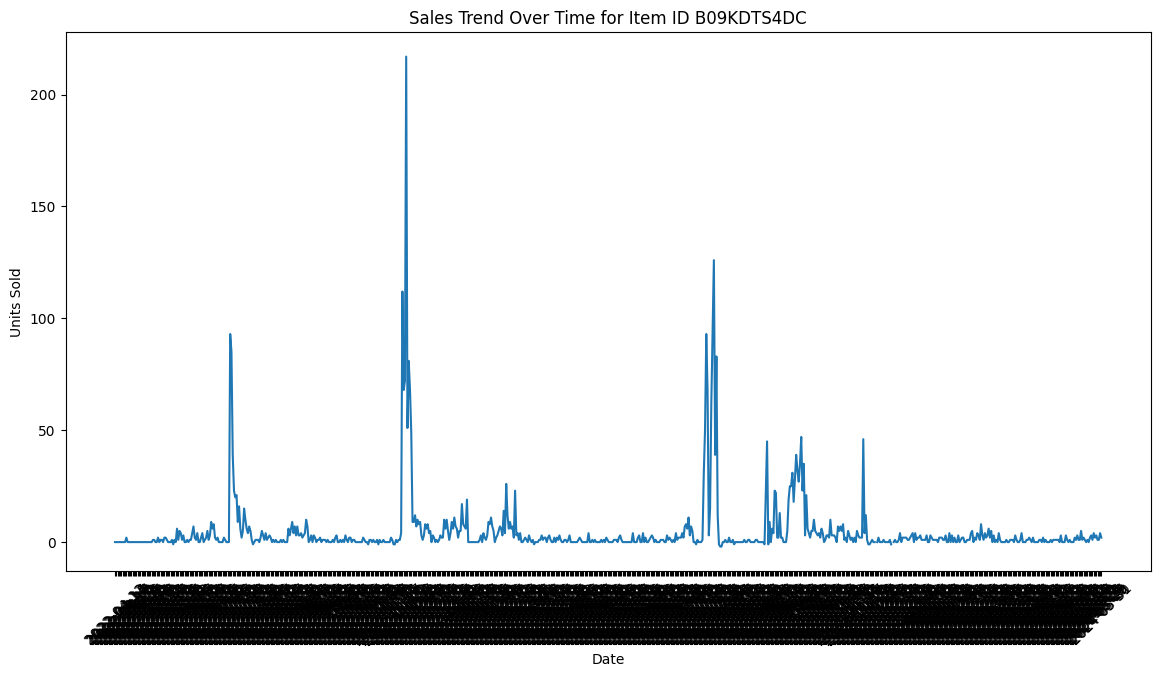

In [ ]:

# Basic information about the datasets
print("Train Dataset Info:")
print(train_df.info())
print("\nTest Dataset Info:")
print(test_df.info())

# Summary statistics
print("\nTrain Dataset Summary:")
print(train_df.describe())

# Check for missing values
print("\nMissing Values in Train Dataset:")
print(train_df.isnull().sum())

# Visualize the distribution of the target variable (units sold)
plt.figure(figsize=(10, 6))
sns.histplot(train_df['units'], bins=50, kde=True)
plt.title('Distribution of Units Sold')
plt.xlabel('Units Sold')
plt.ylabel('Frequency')
plt.show()

# Visualize the trend of sales over time for a sample item
sample_item_id = train_df['Item Id'].unique()[0]
sample_item_df = train_df[train_df['Item Id'] == sample_item_id]

plt.figure(figsize=(14, 7))
plt.plot(sample_item_df['date'], sample_item_df['units'])
plt.title(f'Sales Trend Over Time for Item ID {sample_item_id}')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Remove rows where 'Item Id' or 'Item Name' is missing
train_df = train_df.dropna(subset=['Item Id', 'Item Name'])

# Impute missing 'ad_spend' and 'units' with the median values
train_df['ad_spend'].fillna(train_df['ad_spend'].median(), inplace=True)
train_df['units'].fillna(train_df['units'].median(), inplace=True)

# Verify that there are no more missing values
print("\nMissing Values in Train Dataset After Imputation:")
print(train_df.isnull().sum())



Missing Values in Train Dataset After Imputation:
ID            0
date          0
Item Id       0
Item Name     0
ad_spend      0
anarix_id     0
units         0
unit_price    0
dtype: int64


In [ ]:
# Feature Engineering

# Convert date column to datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Extract date features
train_df['year'] = train_df['date'].dt.year
train_df['month'] = train_df['date'].dt.month
train_df['day'] = train_df['date'].dt.day
train_df['dayofweek'] = train_df['date'].dt.dayofweek
train_df['is_weekend'] = train_df['dayofweek'].isin([5, 6]).astype(int)

test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6]).astype(int)

# Create lag features
for lag in range(1, 8):  # Lag of 1 to 7 days
    train_df[f'units_lag_{lag}'] = train_df.groupby('Item Id')['units'].shift(lag)

# Create rolling statistics features
train_df['rolling_mean_7'] = train_df.groupby('Item Id')['units'].shift(1).rolling(window=7).mean()
train_df['rolling_std_7'] = train_df.groupby('Item Id')['units'].shift(1).rolling(window=7).std()

# Fill NaN values for the new features
train_df.fillna(0, inplace=True)

# Verify the changes
print("\nTrain Dataset with New Features:")
print(train_df.head())



Train Dataset with New Features:
                      ID       date     Item Id  \
0  2022-04-12_B09KDTS4DC 2022-04-12  B09KDTS4DC   
1  2022-04-12_B09MR2MLZH 2022-04-12  B09MR2MLZH   
2  2022-04-12_B09KSYL73R 2022-04-12  B09KSYL73R   
3  2022-04-12_B09KT5HMNY 2022-04-12  B09KT5HMNY   
4  2022-04-12_B09KTF8ZDQ 2022-04-12  B09KTF8ZDQ   

                                           Item Name  ad_spend anarix_id  \
0  NapQueen Elizabeth 8" Gel Memory Foam Mattress...     4.195  NAPQUEEN   
1  NapQueen 12 Inch Bamboo Charcoal Queen Size Me...     4.195  NAPQUEEN   
2     NapQueen Elsa 8" Innerspring Mattress, Twin XL     4.195  NAPQUEEN   
3        NapQueen Elsa 6" Innerspring Mattress, Twin     4.195  NAPQUEEN   
4     NapQueen Elsa 6" Innerspring Mattress, Twin XL     4.195  NAPQUEEN   

   units  unit_price  year  month  ...  is_weekend  units_lag_1  units_lag_2  \
0    0.0         0.0  2022      4  ...           0          0.0          0.0   
1    0.0         0.0  2022      4  ...    

#  I used various models such as RandomForestRegressor GradientBoostingRegressor XGBRegressor LGBMRegressor among this GBR gave the lowest mse so i am continuing with that

In [ ]:

# Selecting features for training
features = ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'ad_spend',
            'unit_price', 'rolling_mean_7', 'rolling_std_7'] + \
           [f'units_lag_{lag}' for lag in range(1, 8)]

# Split the data into training and validation sets
X = train_df[features]
y = train_df['units']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and train the model of RFR
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Validating the model
y_pred = model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print(f'Validation MSE: {mse}')

# Feature Importance
importances = model.feature_importances_
feature_importance = pd.Series(importances, index=features).sort_values(ascending=False)
print("\nFeature Importances:\n", feature_importance)


Validation MSE: 651.086657240104

Feature Importances:
 units_lag_1       0.428206
ad_spend          0.418725
units_lag_6       0.022777
rolling_std_7     0.022588
units_lag_3       0.020091
rolling_mean_7    0.016582
units_lag_5       0.016038
unit_price        0.011032
units_lag_4       0.010745
units_lag_7       0.009717
day               0.007685
units_lag_2       0.007525
dayofweek         0.003821
month             0.002975
year              0.001159
is_weekend        0.000333
dtype: float64


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

# Initializing and train the model
gbr = GradientBoostingRegressor(n_estimators=100, random_state=42)
gbr.fit(X_train, y_train)

# Validating the model
y_pred_gbr = gbr.predict(X_val)
mse_gbr = mean_squared_error(y_val, y_pred_gbr)
print(f'Gradient Boosting Regressor Validation MSE: {mse_gbr}')


Gradient Boosting Regressor Validation MSE: 514.2044580401389


In [ ]:
from xgboost import XGBRegressor

# Initialize and train the model
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(X_train, y_train)

# Validate the model
y_pred_xgb = xgb.predict(X_val)
mse_xgb = mean_squared_error(y_val, y_pred_xgb)
print(f'XGBoost Regressor Validation MSE: {mse_xgb}')


XGBoost Regressor Validation MSE: 839.6709661699313


In [22]:
from lightgbm import LGBMRegressor

# Initialize and train the model
lgbm = LGBMRegressor(n_estimators=100, random_state=42)
lgbm.fit(X_train, y_train)

# Validate the model
y_pred_lgbm = lgbm.predict(X_val)
mse_lgbm = mean_squared_error(y_val, y_pred_lgbm)
print(f'LightGBM Regressor Validation MSE: {mse_lgbm}')


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.040597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 79726, number of used features: 16
[LightGBM] [Info] Start training from score 8.603065
LightGBM Regressor Validation MSE: 1105.675331538166
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031842 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2863
[LightGBM] [Info] Number of data points in the train set: 79726, number of used features: 16
[LightGBM] [Info] Start training from score 8.603065
LightGBM Regressor Validation MSE: 1105.675331538166


In [24]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'n_estimators': [100, 150],
    'learning_rate': [0.01, 0.05],
    'max_depth': [3, 4]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters
print(f'Best parameters: {grid_search.best_params_}')

# Best model
best_gbr = grid_search.best_estimator_


Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 150}


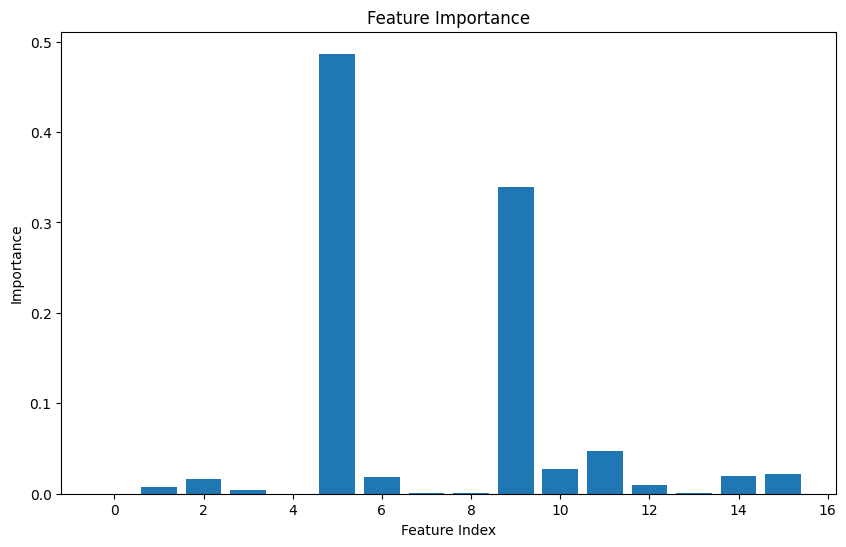

In [25]:
# Feature importance
feature_importance = best_gbr.feature_importances_

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()


In [34]:
# Preparing the test data
# Converting date column to datetime
test_df['date'] = pd.to_datetime(test_df['date'])

# Extracting date features
test_df['year'] = test_df['date'].dt.year
test_df['month'] = test_df['date'].dt.month
test_df['day'] = test_df['date'].dt.day
test_df['dayofweek'] = test_df['date'].dt.dayofweek
test_df['is_weekend'] = test_df['dayofweek'].isin([5, 6]).astype(int)

# Ensuring to fill NaN values for the features present in test_df
test_df['ad_spend'].fillna(test_df['ad_spend'].median(), inplace=True)
test_df['unit_price'].fillna(test_df['unit_price'].median(), inplace=True)

# Adding missing features with default values (0) to the test data
missing_features = ['rolling_mean_7', 'rolling_std_7'] + [f'units_lag_{lag}' for lag in range(1, 8)]
for feature in missing_features:
    test_df[feature] = 0

# Selecting the same features for test data as used in training
features = ['year', 'month', 'day', 'dayofweek', 'is_weekend', 'ad_spend', 'unit_price', 'rolling_mean_7', 'rolling_std_7'] + \
           [f'units_lag_{lag}' for lag in range(1, 8)]

# Selecting the features for test data
X_test = test_df[features]

# Making predictions on the test data
y_test_pred = best_gbr.predict(X_test)




In [35]:
# Creating the submission file with the correct format
# Assuming test_df has a 'date' column you want to include in the ID
test_df['date'] = test_df['date'].dt.strftime('%Y-%m-%d')  # Ensure date format is YYYY-MM-DD

# Creating the ID in the required format (date_Item Id)
submission = pd.DataFrame({
    'ID': test_df['date'] + '_' + test_df['Item Id'],  # Combine date and Item Id
    'TARGET': y_test_pred  # Use predictions as TARGET
})

#finally Save the submission file
submission.to_csv('submission4.csv', index=False)
print("Submission file created with the correct format.")

Submission file created with the correct format.
